## Introduction
To enhance my understanding of the PyTorch framework, I've selected a dataset that I have previously cleaned and prepared specifically for machine learning projects.
To enable GPU functionality, I had to completely remove all NVIDIA software from my computer and perform a fresh installation of the NVIDIA CUDA software. Additionally, creating a new environment from scratch was necessary, as working within the root environment did not yield successful results.

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Device: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Tomas4python/green_taxi_20/master/cleaned_project_data_20.csv')
data

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,total_amount,trip_duration,night,peak_hour,congestion,amount_without_tip
0,2020-01-01 00:45:58,2020-01-01 00:56:39,66,65,1.28,20.0,24.36,641.0,1,0,0,20.30
1,2020-01-01 00:41:38,2020-01-01 00:52:49,181,228,2.47,10.5,15.34,671.0,1,0,0,11.80
2,2020-01-01 00:52:46,2020-01-01 01:14:21,129,263,6.30,21.0,25.05,1295.0,1,0,1,25.05
3,2020-01-01 00:19:57,2020-01-01 00:30:56,210,150,2.30,10.0,11.30,659.0,1,0,0,11.30
4,2020-01-01 00:52:33,2020-01-01 01:09:54,35,39,3.00,13.5,14.80,1041.0,1,0,0,14.80
...,...,...,...,...,...,...,...,...,...,...,...,...
1128350,2020-12-31 23:08:35,2020-12-31 23:13:00,41,74,0.79,5.0,6.30,265.0,1,0,0,6.30
1128351,2020-12-31 23:11:04,2020-12-31 23:20:08,41,116,2.31,12.0,12.30,544.0,1,0,0,12.30
1128352,2020-12-31 23:24:33,2020-12-31 23:40:24,116,119,5.73,20.0,20.30,951.0,1,0,0,20.30
1128353,2020-12-31 23:13:59,2020-12-31 23:16:20,42,42,0.31,3.5,4.80,141.0,1,0,0,4.80


## Data Preprocessing

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
data.columns.to_list()

['lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_distance',
 'fare_amount',
 'total_amount',
 'trip_duration',
 'night',
 'peak_hour',
 'congestion',
 'amount_without_tip']

In [6]:
X = data[[
            'PULocationID',
            'DOLocationID',
            'trip_distance',
            'trip_duration',
            'night',
            'peak_hour',
            'congestion',
]].values
y = data['amount_without_tip'].values
print(X.shape)
print(y.shape)

(1128355, 7)
(1128355,)


In [7]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=22)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=22)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train

array([[-0.88907751, -0.72000288, -0.51181223, ..., -0.54964112,
        -0.5276932 , -0.47829835],
       [ 2.39032756,  1.38272242,  1.97342404, ..., -0.54964112,
        -0.5276932 , -0.47829835],
       [ 0.4286743 , -0.61551963, -0.63579227, ...,  1.81936896,
        -0.5276932 , -0.47829835],
       ...,
       [-0.05050818,  1.14763512, -0.21313304, ..., -0.54964112,
        -0.5276932 , -0.47829835],
       [-0.05050818, -0.82448612, -0.3991031 , ..., -0.54964112,
        -0.5276932 , -0.47829835],
       [ 0.84795897,  0.10280268,  0.57583086, ..., -0.54964112,
        -0.5276932 ,  2.09074523]])

In [9]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train[:, None], dtype=torch.float32)

X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val[:, None], dtype=torch.float32)

X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test[:, None], dtype=torch.float32)

print(X_train_torch.shape)
print(y_train_torch.shape)

torch.Size([789848, 7])
torch.Size([789848, 1])


In [10]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128

train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Model Definition

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# class RegressionModel(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(RegressionModel, self).__init__()
#         self.fc1 = nn.Linear(input_size, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, output_size)
    
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return self.fc3(x)

# input_size = 7
# output_size = 1
# model = RegressionModel(input_size, output_size).to(device)

class RegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

input_size = X_train.shape[1]
output_size = 1
model = RegressionModel(input_size, output_size).to(device)

## Model Training

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 200
train_losses = []
val_losses = []
patience = 25
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            val_running_loss += val_loss.item()
    
    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the model if it's the best seen so far
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered")
        break


Epoch 1, Training Loss: 8.438136798001402, Validation Loss: 5.844273112243374
Epoch 2, Training Loss: 6.125625828080926, Validation Loss: 5.6658861323114715
Epoch 3, Training Loss: 6.056268019158302, Validation Loss: 6.496995938483533
Epoch 4, Training Loss: 5.9895265428613484, Validation Loss: 5.7613526419242405
Epoch 5, Training Loss: 5.935799341368107, Validation Loss: 5.738270549654422
Epoch 6, Training Loss: 5.898002311645286, Validation Loss: 5.6416903759939405
Epoch 7, Training Loss: 5.853395467500616, Validation Loss: 5.538042733685427
Epoch 8, Training Loss: 5.837503155033895, Validation Loss: 5.616984428438457
Epoch 9, Training Loss: 5.784334658233838, Validation Loss: 5.5216806586285205
Epoch 10, Training Loss: 5.784432502264549, Validation Loss: 5.542460352014204
Epoch 11, Training Loss: 5.772204016044487, Validation Loss: 5.804295369871718
Epoch 12, Training Loss: 5.756205414507729, Validation Loss: 6.7993409517925425
Epoch 13, Training Loss: 5.742779547298212, Validation 

## Model Evaluation

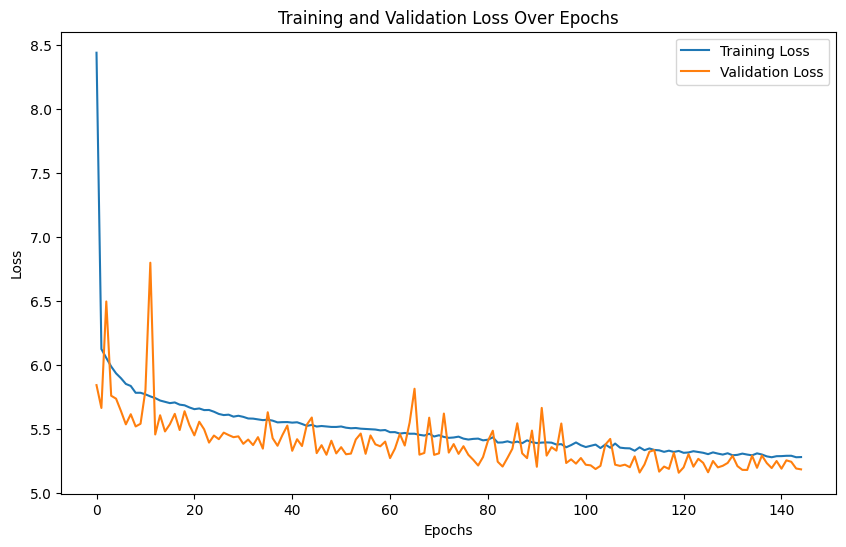

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [14]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()

test_loss = 0.0
total_samples = 0
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        predictions.extend(outputs.view(-1).cpu().numpy())
        actuals.extend(targets.view(-1).cpu().numpy())

average_test_loss = test_loss / total_samples
print(f'Average Test Loss: {average_test_loss}')

Average Test Loss: 5.942917888691351


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mean_test_data = np.mean(actuals)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean of Test Data Targets: {mean_test_data}')


Mean Absolute Error (MAE): 0.6741873621940613
Mean Squared Error (MSE): 5.942917346954346
Root Mean Squared Error (RMSE): 2.437809944152832
Mean of Test Data Targets: 14.267934799194336
